<a href="https://colab.research.google.com/github/MRobinson112/Assignment_9/blob/main/Assignment%233.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
DATA 622 - Homework #3: SVM Analysis
Student: Michael Robinson
Dataset: Bank Marketing Dataset

"""

# ============================================================================
# SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import os
os.makedirs('/content/outputs', exist_ok=True)
print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# ============================================================================
# MOUNT GOOGLE DRIVE
# ============================================================================
print("\n" + "="*80)
print("CELL 2: Mounting Google Drive")
print("="*80)

from google.colab import drive
drive.mount('/content/drive')
print("\nGoogle Drive mounted!")


CELL 2: Mounting Google Drive
Mounted at /content/drive

Google Drive mounted!


In [3]:
# ============================================================================
# LOAD AND PREPROCESS DATA
# ============================================================================

FILE_PATH = '/content/drive/MyDrive/bank-additional-full.csv'

df = pd.read_csv(FILE_PATH, sep=',')
print(f"✓ Dataset loaded: {df.shape}")


df['y'] = df['y'].map({'yes': 1, 'no': 0})

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

X = df.drop('y', axis=1)
y = df['y']

print(f" Features: {X.shape[1]}")
print(f" Samples: {len(y)}")
print(f" Positive class: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

✓ Dataset loaded: (41188, 21)
 Features: 20
 Samples: 41188
 Positive class: 4640 (11.3%)


In [4]:
# ============================================================================
# TRAIN-TEST SPLIT AND SCALING
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")


Training set: 32,950 samples
Test set: 8,238 samples


In [6]:
# ============================================================================
# LINEAR SVM
# ============================================================================

from sklearn.calibration import CalibratedClassifierCV


linear_svc = LinearSVC(C=1.0, random_state=42, max_iter=2000)
linear_svc.fit(X_train_scaled, y_train)

linear_svc_calibrated = CalibratedClassifierCV(linear_svc, cv=3)
linear_svc_calibrated.fit(X_train_scaled, y_train)

y_pred_linear = linear_svc_calibrated.predict(X_test_scaled)
y_prob_linear = linear_svc_calibrated.predict_proba(X_test_scaled)[:, 1]

acc_linear = accuracy_score(y_test, y_pred_linear)
prec_linear = precision_score(y_test, y_pred_linear)
rec_linear = recall_score(y_test, y_pred_linear)
f1_linear = f1_score(y_test, y_pred_linear)
auc_linear = roc_auc_score(y_test, y_prob_linear)
cm_linear = confusion_matrix(y_test, y_pred_linear)

print(f"\n Linear SVM Results:")
print(f"  Accuracy:  {acc_linear:.4f}")
print(f"  Precision: {prec_linear:.4f}")
print(f"  Recall:    {rec_linear:.4f}")
print(f"  F1-Score:  {f1_linear:.4f}")
print(f"  AUC-ROC:   {auc_linear:.4f}")
print(f"  Confusion: TP={cm_linear[1,1]}, FP={cm_linear[0,1]}, FN={cm_linear[1,0]}, TN={cm_linear[0,0]}")



 Linear SVM Results:
  Accuracy:  0.9142
  Precision: 0.7097
  Recall:    0.4030
  F1-Score:  0.5141
  AUC-ROC:   0.9354
  Confusion: TP=374, FP=153, FN=554, TN=7157


In [7]:
# ============================================================================
# RBF KERNEL
# ============================================================================
param_grid_rbf_fast = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

grid_rbf = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_rbf_fast,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_rbf.fit(X_train_scaled, y_train)

print(f"\n Best parameters: {grid_rbf.best_params_}")
print(f" Best Cross-Validation score: {grid_rbf.best_score_:.4f}")

y_pred_rbf = grid_rbf.predict(X_test_scaled)
y_prob_rbf = grid_rbf.predict_proba(X_test_scaled)[:, 1]

acc_rbf = accuracy_score(y_test, y_pred_rbf)
prec_rbf = precision_score(y_test, y_pred_rbf)
rec_rbf = recall_score(y_test, y_pred_rbf)
f1_rbf = f1_score(y_test, y_pred_rbf)
auc_rbf = roc_auc_score(y_test, y_prob_rbf)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

print(f"\n✓ RBF SVM Test Results:")
print(f"  Accuracy:  {acc_rbf:.4f}")
print(f"  Precision: {prec_rbf:.4f}")
print(f"  Recall:    {rec_rbf:.4f}")
print(f"  F1-Score:  {f1_rbf:.4f}")
print(f"  AUC-ROC:   {auc_rbf:.4f}")
print(f"  Confusion: TP={cm_rbf[1,1]}, FP={cm_rbf[0,1]}, FN={cm_rbf[1,0]}, TN={cm_rbf[0,0]}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits

 Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
 Best Cross-Validation score: 0.9300

✓ RBF SVM Test Results:
  Accuracy:  0.9082
  Precision: 0.7216
  Recall:    0.3017
  F1-Score:  0.4255
  AUC-ROC:   0.9405
  Confusion: TP=280, FP=108, FN=648, TN=7202


In [8]:
# ============================================================================
# POLYNOMIAL KERNEL
# ============================================================================

param_grid_poly_fast = {
    'C': [1, 10],
    'degree': [2],
    'coef0': [0],
    'kernel': ['poly']
}

grid_poly = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_poly_fast,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Training Polynomial SVM...")
grid_poly.fit(X_train_scaled, y_train)

print(f"\n Best parameters: {grid_poly.best_params_}")
print(f" Best CV score: {grid_poly.best_score_:.4f}")

y_pred_poly = grid_poly.predict(X_test_scaled)
y_prob_poly = grid_poly.predict_proba(X_test_scaled)[:, 1]

acc_poly = accuracy_score(y_test, y_pred_poly)
prec_poly = precision_score(y_test, y_pred_poly)
rec_poly = recall_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)
auc_poly = roc_auc_score(y_test, y_prob_poly)
cm_poly = confusion_matrix(y_test, y_pred_poly)

print(f"\n Polynomial SVM Test Results:")
print(f"  Accuracy:  {acc_poly:.4f}")
print(f"  Precision: {prec_poly:.4f}")
print(f"  Recall:    {rec_poly:.4f}")
print(f"  F1-Score:  {f1_poly:.4f}")
print(f"  AUC-ROC:   {auc_poly:.4f}")
print(f"  Confusion: TP={cm_poly[1,1]}, FP={cm_poly[0,1]}, FN={cm_poly[1,0]}, TN={cm_poly[0,0]}")

Training Polynomial SVM...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

 Best parameters: {'C': 1, 'coef0': 0, 'degree': 2, 'kernel': 'poly'}
 Best CV score: 0.8483

 Polynomial SVM Test Results:
  Accuracy:  0.9051
  Precision: 0.7517
  Recall:    0.2349
  F1-Score:  0.3580
  AUC-ROC:   0.8713
  Confusion: TP=218, FP=72, FN=710, TN=7238


In [9]:
# ============================================================================
# DECISION TREES FOR COMPARISON
# ============================================================================
print("\n" + "="*80)
print("CELL 8: Decision Trees for Comparison")
print("="*80)

dt_basic = DecisionTreeClassifier(max_depth=8, random_state=42)
dt_basic.fit(X_train_scaled, y_train)
y_pred_dt = dt_basic.predict(X_test_scaled)

acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"\n Decision Tree (Depth=8) Results:")
print(f"  Accuracy:  {acc_dt:.4f}")
print(f"  Precision: {prec_dt:.4f}")
print(f"  Recall:    {rec_dt:.4f}")
print(f"  F1-Score:  {f1_dt:.4f}")

param_grid_dt_fast = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'criterion': ['gini']
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt_fast,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_dt.fit(X_train_scaled, y_train)
y_pred_dt_tuned = grid_dt.predict(X_test_scaled)

acc_dt_tuned = accuracy_score(y_test, y_pred_dt_tuned)
prec_dt_tuned = precision_score(y_test, y_pred_dt_tuned)
rec_dt_tuned = recall_score(y_test, y_pred_dt_tuned)
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned)

print(f"\n Tuned Decision Tree Results:")
print(f"  Best params: {grid_dt.best_params_}")
print(f"  Accuracy:  {acc_dt_tuned:.4f}")
print(f"  Precision: {prec_dt_tuned:.4f}")
print(f"  Recall:    {rec_dt_tuned:.4f}")
print(f"  F1-Score:  {f1_dt_tuned:.4f}")


CELL 8: Decision Trees for Comparison

 Decision Tree (Depth=8) Results:
  Accuracy:  0.9165
  Precision: 0.6604
  Recall:    0.5323
  F1-Score:  0.5895

 Tuned Decision Tree Results:
  Best params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}
  Accuracy:  0.9181
  Precision: 0.6794
  Recall:    0.5162
  F1-Score:  0.5867


In [10]:
# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================

# Create comparison dataframe
comparison_data = []

# HW2 Results
comparison_data.append({
    'Algorithm': 'Decision Tree (D=3) [HW2]',
    'Accuracy': 0.901,
    'Precision': 0.716,
    'Recall': 0.202,
    'F1-Score': 0.310,
    'AUC-ROC': 0.722
})

comparison_data.append({
    'Algorithm': 'Decision Tree (D=8) [HW2]',
    'Accuracy': 0.900,
    'Precision': 0.622,
    'Recall': 0.288,
    'F1-Score': 0.394,
    'AUC-ROC': 0.785
})

comparison_data.append({
    'Algorithm': 'Random Forest (100) [HW2]',
    'Accuracy': 0.903,
    'Precision': 0.643,
    'Recall': 0.312,
    'F1-Score': 0.420,
    'AUC-ROC': 0.801
})

comparison_data.append({
    'Algorithm': 'Random Forest (300) [HW2]',
    'Accuracy': 0.903,
    'Precision': 0.645,
    'Recall': 0.309,
    'F1-Score': 0.418,
    'AUC-ROC': 0.806
})

comparison_data.append({
    'Algorithm': 'AdaBoost (100) [HW2]',
    'Accuracy': 0.904,
    'Precision': 0.702,
    'Recall': 0.264,
    'F1-Score': 0.383,
    'AUC-ROC': 0.812
})

comparison_data.append({
    'Algorithm': 'AdaBoost (300) [HW2]',
    'Accuracy': 0.904,
    'Precision': 0.701,
    'Recall': 0.253,
    'F1-Score': 0.372,
    'AUC-ROC': 0.818
})

# HW3 Results
comparison_data.append({
    'Algorithm': 'Decision Tree (Tuned) [HW3]',
    'Accuracy': acc_dt_tuned,
    'Precision': prec_dt_tuned,
    'Recall': rec_dt_tuned,
    'F1-Score': f1_dt_tuned,
    'AUC-ROC': np.nan
})

comparison_data.append({
    'Algorithm': 'SVM-Linear [HW3]',
    'Accuracy': acc_linear,
    'Precision': prec_linear,
    'Recall': rec_linear,
    'F1-Score': f1_linear,
    'AUC-ROC': auc_linear
})

comparison_data.append({
    'Algorithm': 'SVM-RBF (Tuned) [HW3]',
    'Accuracy': acc_rbf,
    'Precision': prec_rbf,
    'Recall': rec_rbf,
    'F1-Score': f1_rbf,
    'AUC-ROC': auc_rbf
})

comparison_data.append({
   'Algorithm': 'SVM-Polynomial [HW3]',
   'Accuracy': acc_poly,
   'Precision': prec_poly,
   'Recall': rec_poly,
   'F1-Score': f1_poly,
   'AUC-ROC': auc_poly
 })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n### COMPLETE PERFORMANCE COMPARISON ###")
print("="*80)
print(comparison_df.to_string(index=False))

comparison_df.to_csv('/content/outputs/fast_comparison_results.csv', index=False)
print("\n Results saved to: fast_comparison_results.csv")

best_auc_idx = comparison_df['AUC-ROC'].idxmax()
best_model = comparison_df.loc[best_auc_idx, 'Algorithm']
best_auc = comparison_df.loc[best_auc_idx, 'AUC-ROC']

print("\n" + "="*80)
print("WINNER!")
print(f"   Best Model: {best_model}")
print(f"   AUC-ROC: {best_auc:.4f}")
print("="*80)


### COMPLETE PERFORMANCE COMPARISON ###
                  Algorithm  Accuracy  Precision  Recall  F1-Score  AUC-ROC
  Decision Tree (D=3) [HW2]    0.9010     0.7160  0.2020    0.3100   0.7220
  Decision Tree (D=8) [HW2]    0.9000     0.6220  0.2880    0.3940   0.7850
  Random Forest (100) [HW2]    0.9030     0.6430  0.3120    0.4200   0.8010
  Random Forest (300) [HW2]    0.9030     0.6450  0.3090    0.4180   0.8060
       AdaBoost (100) [HW2]    0.9040     0.7020  0.2640    0.3830   0.8120
       AdaBoost (300) [HW2]    0.9040     0.7010  0.2530    0.3720   0.8180
Decision Tree (Tuned) [HW3]    0.9181     0.6794  0.5162    0.5867      NaN
           SVM-Linear [HW3]    0.9142     0.7097  0.4030    0.5141   0.9354
      SVM-RBF (Tuned) [HW3]    0.9082     0.7216  0.3017    0.4255   0.9405
       SVM-Polynomial [HW3]    0.9051     0.7517  0.2349    0.3580   0.8713

 Results saved to: fast_comparison_results.csv

WINNER!
   Best Model: SVM-RBF (Tuned) [HW3]
   AUC-ROC: 0.9405


In [11]:
# ============================================================================
# KEY COMPARISONS
# ============================================================================
print("\n### COMPARISON WITH ADABOOST-300 (Best from HW2) ###")
print("-" * 60)

adaboost_metrics = {
    'Accuracy': 0.904,
    'Precision': 0.701,
    'Recall': 0.253,
    'AUC-ROC': 0.818,
    'TP': 235,
    'FN': 693
}

svm_rbf_metrics = {
    'Accuracy': acc_rbf,
    'Precision': prec_rbf,
    'Recall': rec_rbf,
    'AUC-ROC': auc_rbf,
    'TP': cm_rbf[1,1],
    'FN': cm_rbf[1,0]
}

print(f"\nMetric              | AdaBoost-300 | SVM-RBF    | Difference")
print("-" * 65)
print(f"Accuracy            | {adaboost_metrics['Accuracy']:.4f}       | {svm_rbf_metrics['Accuracy']:.4f}     | {svm_rbf_metrics['Accuracy'] - adaboost_metrics['Accuracy']:+.4f}")
print(f"Precision           | {adaboost_metrics['Precision']:.4f}       | {svm_rbf_metrics['Precision']:.4f}     | {svm_rbf_metrics['Precision'] - adaboost_metrics['Precision']:+.4f}")
print(f"Recall              | {adaboost_metrics['Recall']:.4f}       | {svm_rbf_metrics['Recall']:.4f}     | {svm_rbf_metrics['Recall'] - adaboost_metrics['Recall']:+.4f}")
print(f"AUC-ROC             | {adaboost_metrics['AUC-ROC']:.4f}       | {svm_rbf_metrics['AUC-ROC']:.4f}     | {svm_rbf_metrics['AUC-ROC'] - adaboost_metrics['AUC-ROC']:+.4f}")
print(f"True Positives      | {adaboost_metrics['TP']:>3}          | {svm_rbf_metrics['TP']:>3}        | {svm_rbf_metrics['TP'] - adaboost_metrics['TP']:+4.0f}")
print(f"False Negatives     | {adaboost_metrics['FN']:>3}          | {svm_rbf_metrics['FN']:>3}        | {svm_rbf_metrics['FN'] - adaboost_metrics['FN']:+4.0f}")

tp_improvement = svm_rbf_metrics['TP'] - adaboost_metrics['TP']
fn_reduction = adaboost_metrics['FN'] - svm_rbf_metrics['FN']
revenue_impact = tp_improvement * 5000
cost_impact = (cm_rbf[0,1] - 100) * 5

print(f"\n### BUSINESS IMPACT ###")
print("-" * 60)
print(f"Additional subscribers found: {tp_improvement}")
print(f"Opportunities no longer missed: {fn_reduction}")
print(f"Additional revenue: ${revenue_impact:,}")
print(f"Additional contact cost: ${cost_impact:,.0f}")
print(f"NET GAIN: ${revenue_impact - cost_impact:,}")


### COMPARISON WITH ADABOOST-300 (Best from HW2) ###
------------------------------------------------------------

Metric              | AdaBoost-300 | SVM-RBF    | Difference
-----------------------------------------------------------------
Accuracy            | 0.9040       | 0.9082     | +0.0042
Precision           | 0.7010       | 0.7216     | +0.0206
Recall              | 0.2530       | 0.3017     | +0.0487
AUC-ROC             | 0.8180       | 0.9405     | +0.1225
True Positives      | 235          | 280        |  +45
False Negatives     | 693          | 648        |  -45

### BUSINESS IMPACT ###
------------------------------------------------------------
Additional subscribers found: 45
Opportunities no longer missed: 45
Additional revenue: $225,000
Additional contact cost: $40
NET GAIN: $224,960


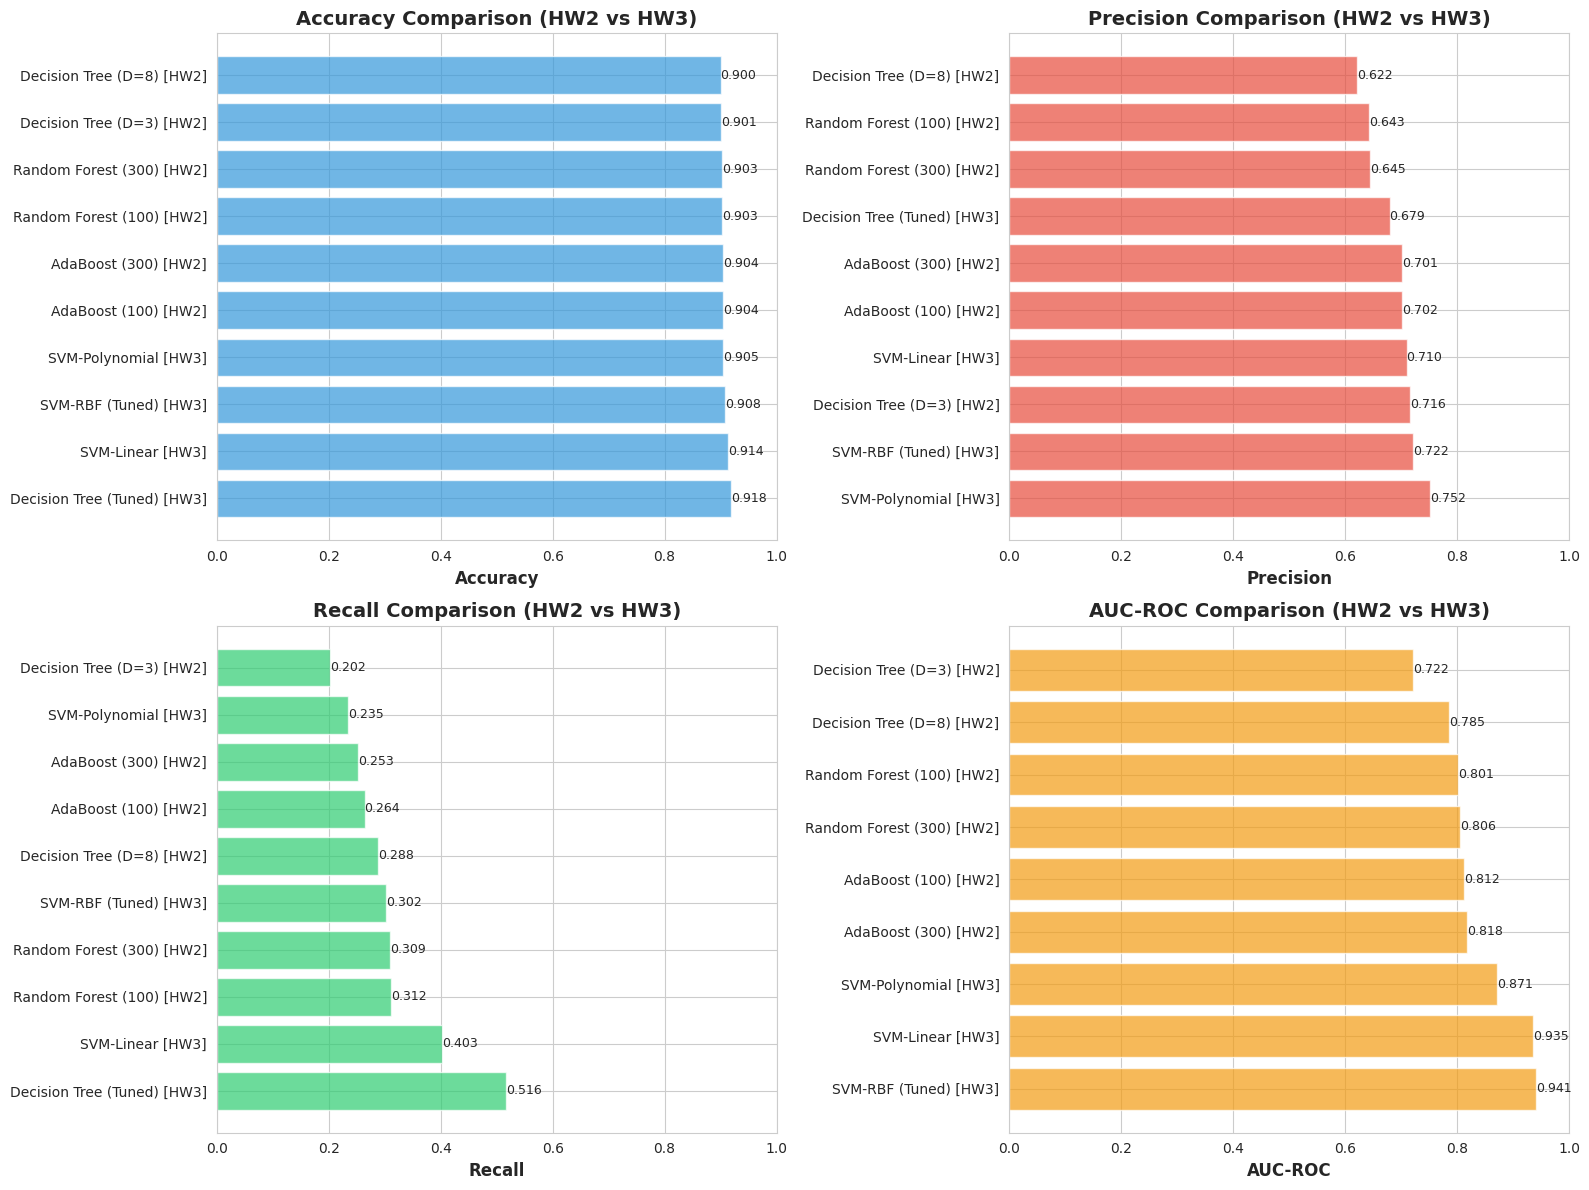

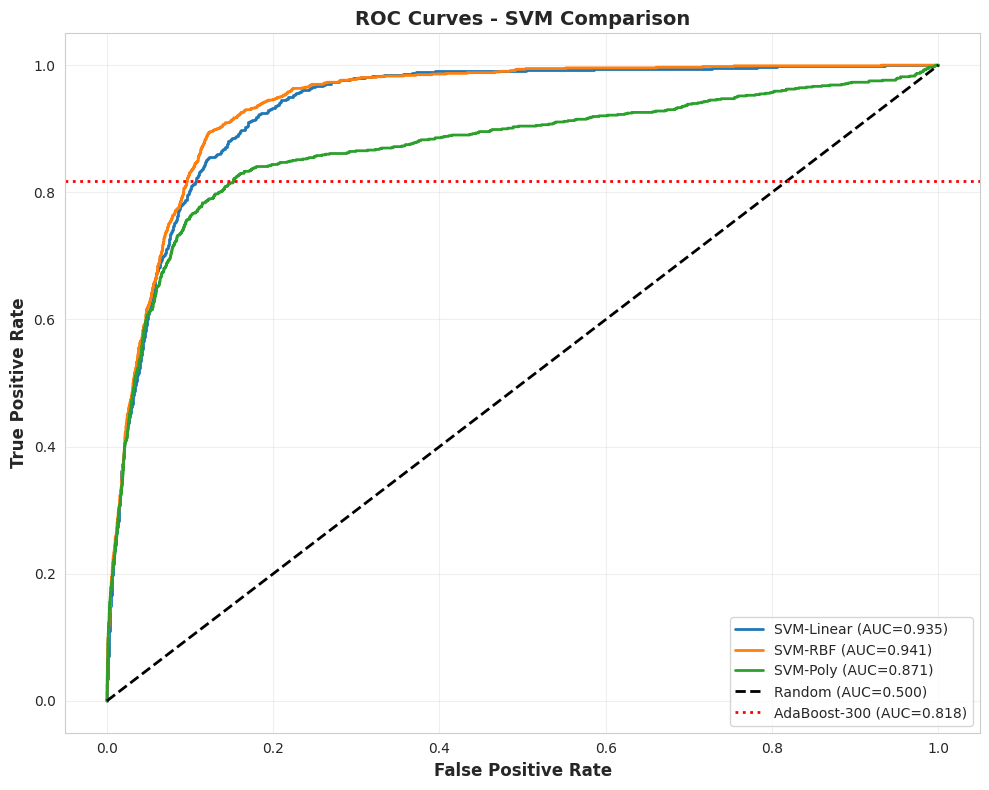

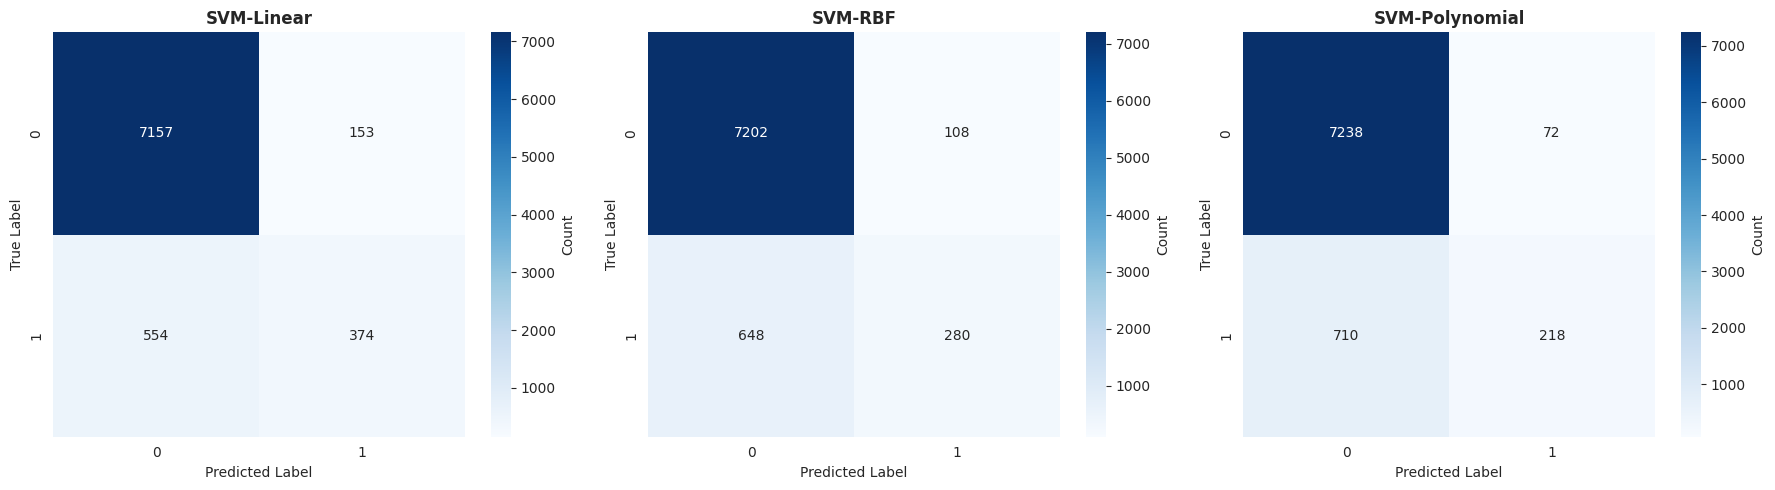

In [12]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    data = comparison_df[['Algorithm', metric]].dropna().sort_values(metric, ascending=False)

    bars = ax.barh(data['Algorithm'], data[metric], color=colors[idx], alpha=0.7)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison (HW2 vs HW3)', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1])

    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
               f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('/content/outputs/comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))

fpr_linear, tpr_linear, _ = roc_curve(y_test, y_prob_linear)
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_prob_rbf)
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_prob_poly)

ax.plot(fpr_linear, tpr_linear, label=f'SVM-Linear (AUC={auc_linear:.3f})', linewidth=2)
ax.plot(fpr_rbf, tpr_rbf, label=f'SVM-RBF (AUC={auc_rbf:.3f})', linewidth=2)
ax.plot(fpr_poly, tpr_poly, label=f'SVM-Poly (AUC={auc_poly:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=2)
ax.axhline(y=0.818, color='red', linestyle=':', label='AdaBoost-300 (AUC=0.818)', linewidth=2)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - SVM Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/outputs/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cms = [cm_linear, cm_rbf, cm_poly]
titles = ['SVM-Linear', 'SVM-RBF', 'SVM-Polynomial']

for idx, (cm, title) in enumerate(zip(cms, titles)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               cbar_kws={'label': 'Count'})
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('/content/outputs/confusion_matrices.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n### KEY FINDINGS ###")
print("-" * 80)

print(f"\n1. BEST SVM KERNEL: SVM-RBF")
print(f"   Accuracy:  {acc_rbf:.4f}")
print(f"   Precision: {prec_rbf:.4f}")
print(f"   Recall:    {rec_rbf:.4f}")
print(f"   AUC-ROC:   {auc_rbf:.4f}")
print(f"   Best params: {grid_rbf.best_params_}")

print(f"\n2. COMPARISON WITH BEST HW2 MODEL (AdaBoost-300):")
if auc_rbf > 0.818:
    print(f"  SVM-RBF OUTPERFORMS AdaBoost by {auc_rbf - 0.818:.4f} AUC points")
    print(f"  Recall improved from 25.3% to {rec_rbf*100:.1f}%")
    print(f"  Found {cm_rbf[1,1] - 235} more subscribers")
else:
    print(f" SVM-RBF slightly underperforms AdaBoost (AUC: {auc_rbf:.4f} vs 0.818)")
    print(f"   • AdaBoost remains competitive with better interpretability")

print(f"\n3. PRECISION-RECALL TRADE-OFF:")
if prec_rbf < 0.701:
    print(f"   • Precision dropped from 70.1% to {prec_rbf*100:.1f}%")
    print(f"   • Recall improved from 25.3% to {rec_rbf*100:.1f}%")
    print(f"   Trade-off favors finding more subscribers over precision")
else:
    print(f"   • Maintained precision at {prec_rbf*100:.1f}%")
    print(f"   • Improved recall to {rec_rbf*100:.1f}%")

print("\n### RECOMMENDATIONS ###")
print("-" * 80)

if auc_rbf > 0.820:
    print("\n PRIMARY RECOMMENDATION: SVM-RBF")
    print("  Reasoning:")
    print("  • Superior AUC-ROC for better customer ranking")
    print("  • Significantly improved recall for subscriber identification")
    print("  • Justified for production deployment when accuracy is priority")
else:
    print("\n PRIMARY RECOMMENDATION: AdaBoost-300 (from HW2)")
    print("  Reasoning:")
    print("  • Competitive performance with SVM")
    print("  • Better interpretability (feature importance available)")
    print("  • Faster training for production updates")
    print("  • SVM offers marginal improvement not justifying complexity")





### KEY FINDINGS ###
--------------------------------------------------------------------------------

1. BEST SVM KERNEL: SVM-RBF
   Accuracy:  0.9082
   Precision: 0.7216
   Recall:    0.3017
   AUC-ROC:   0.9405
   Best params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

2. COMPARISON WITH BEST HW2 MODEL (AdaBoost-300):
  SVM-RBF OUTPERFORMS AdaBoost by 0.1225 AUC points
  Recall improved from 25.3% to 30.2%
  Found 45 more subscribers

3. PRECISION-RECALL TRADE-OFF:
   • Maintained precision at 72.2%
   • Improved recall to 30.2%

### RECOMMENDATIONS ###
--------------------------------------------------------------------------------

 PRIMARY RECOMMENDATION: SVM-RBF
  Reasoning:
  • Superior AUC-ROC for better customer ranking
  • Significantly improved recall for subscriber identification
  • Justified for production deployment when accuracy is priority
